Feature matrix shape: torch.Size([8, 3])
Target vector shape: torch.Size([8, 1])

First 5 (scaled) feature rows:
 tensor([[-0.7538, -0.4743,  0.4620],
        [-0.2752, -0.4743, -0.1980],
        [-0.0359,  0.7115,  0.1980],
        [ 0.3829,  0.7115, -0.5940],
        [-1.4718, -1.6602,  1.7820]])
First 5 target rows:
 tensor([[245.],
        [312.],
        [279.],
        [308.],
        [199.]])

Model architecture:
 MultiLinearReg(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)
linear.weight: (1, 3)
linear.bias: (1,)
Epoch 500: Train MSE = 66266.2578, Test MSE = 65109.6406
Epoch 1000: Train MSE = 45171.2656, Test MSE = 47815.8477
Epoch 1500: Train MSE = 29536.4844, Test MSE = 33576.3594
Epoch 2000: Train MSE = 18360.4199, Test MSE = 22413.1875
Epoch 2500: Train MSE = 10711.9678, Test MSE = 13811.9502
Epoch 3000: Train MSE = 5764.2339, Test MSE = 7551.3516
Epoch 3500: Train MSE = 2813.6738, Test MSE = 3465.9153
Epoch 4000: Train MSE = 1252.3802, Test MSE = 1225.0352

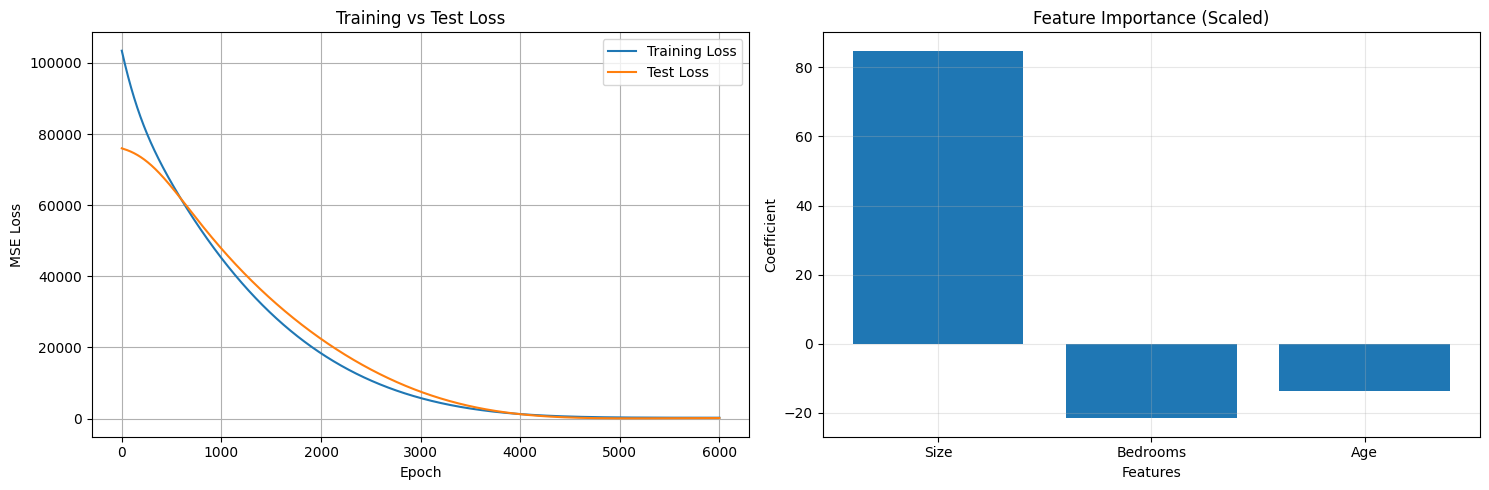

In [44]:
# --------------------
# Import PyTorch and Required Libraries
# --------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# HOUSING DATASET: [SIZE (SQFT), BEDROOMS, AGE (YEARS)] -> PRICE ($1000S)
# --------------------
data = np.array([
    [1400., 3., 20.],
    [1600., 3., 15.],
    [1700., 4., 18.],
    [1875., 4., 12.],
    [1100., 2., 30.],
    [1550., 3., 24.],
    [2350., 4., 7. ],
    [2450., 5., 5. ],
    [1425., 3., 20.],
    [1700., 3., 14.]
], dtype=np.float32)

y_data = np.array([[245.], [312.], [279.], [308.], [199.], [265.], [420.], [460.], [250.], [300.]], dtype=np.float32)

# --------------------
# Device agnostic code
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = torch.tensor(data, dtype=torch.float32, device=device)
y = torch.tensor(y_data, dtype=torch.float32, device=device)

# Feature normalization
def normalize_features(X):
    return (X - X.mean(dim=0)) / X.std(dim=0)

X_normalized = normalize_features(X)

# -----------------------
# 80/20 Train/Test split
# -----------------------
split = int(len(data)*0.8)
X_train, y_train = X_normalized[:split], y[:split]
X_test,  y_test  = X_normalized[split:], y[split:]

print("Feature matrix shape:", X_train.shape)
print("Target vector shape:", y_train.shape)
print("\nFirst 5 (scaled) feature rows:\n", X_train[:5])
print("First 5 target rows:\n", y_train[:5])

# --------------------
# Build the Multiple Linear Regression Model
# --------------------
class MultiLinearReg(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

    def forward(self, x):
        return self.linear(x)

model = MultiLinearReg(in_dim=3).to(device)

print("\nModel architecture:\n", model)
for name, p in model.named_parameters():
    print(f"{name}: {tuple(p.shape)}")

# --------------------
# Define Loss Function and Optimizer
# --------------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# --------------------
# Train the Model
# --------------------
loss_history = []
test_loss_history = []

EPOCHS = 6000

for epoch in range(EPOCHS):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

        # track train and test loss
        loss_history.append(loss.item())
        test_loss_history.append(test_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}: Train MSE = {loss.item():.4f}, Test MSE = {test_loss.item():.4f}")

print("\nTraining completed!")

# --------------------
# Evaluate
# --------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test)

ss_total = torch.sum((y_test - y_test.mean()) ** 2)
ss_residual = torch.sum((y_test - predictions) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print("\nFinal Model Performance:")
print(f"Final Train MSE: {loss_history[-1]:.4f}")
print(f"Final Test MSE: {test_loss_history[-1]:.4f}")
print(f"R-squared Score: {r_squared.item():.4f}")

# weight extraction
print("\nLearned Weights (on SCALED features):")
w = model.linear.weight.detach().cpu().numpy().flatten()
b = model.linear.bias.detach().cpu().item()
print(f"weights: {w}")
print(f"bias: {b:.4f}")

# --------------------
# Actual vs Predicted (CPU arrays for plotting)
# --------------------
Y_cpu = y_test.detach().cpu().numpy().flatten()
pred_cpu = predictions.detach().cpu().numpy().flatten()

print("\nActual vs Predicted Prices:")
print("Actual\tPredicted\tDiff\tError %")
for a, p in zip(Y_cpu, pred_cpu):
    error_pct = ((a - p) / a) * 100
    print(f"{a:.1f}\t{p:.1f}\t\t{(a - p):+.1f}\t{error_pct:+.1f}%")

# --------------------
# Plots
# --------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
features = ['Size', 'Bedrooms', 'Age']
plt.bar(features, w)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance (Scaled)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Example: Predict price for a new house
def predict_house_price(size, bedrooms, age):
    # Create tensor for new house
    new_house = torch.tensor([[size, bedrooms, age]], dtype=torch.float32)

    # Make prediction
    with torch.no_grad():
        predicted_price = model(new_house)

    return predicted_price.item()

# Test predictions
test_houses = [
    (1800, 3, 10),   # Medium house, 3 bedrooms, fairly new
    (2200, 4, 5),    # Large house, 4 bedrooms, very new
    (1200, 2, 25)    # Small house, 2 bedrooms, older
]

print("Price Predictions for New Houses:")
print("Size\tBedrooms\tAge\tPredicted Price")
for size, bedrooms, age in test_houses:
    price = predict_house_price(size, bedrooms, age)
    print(f"{size}\t{bedrooms}\t\t{age}\t${price:.0f}.000")


Price Predictions for New Houses:
Size	Bedrooms	Age	Predicted Price
1800	3		10	$152834.000
2200	4		5	$186821.000
1200	2		25	$101740.000
